In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn


EDA

In [2]:
df=pd.read_csv('C:\\Users\\Surface Book\\Desktop\\Project 1 - Covid Vaccination\\country_vaccinations.csv',index_col='date',parse_dates=True)
df=df[['country', 'iso_code', 'people_vaccinated_per_hundred']]
df.sample(3)

,country,iso_code,people_vaccinated_per_hundred
date,,,
2021-06-20,Canada,CAN,66.52
2021-04-21,Saint Lucia,LCA,NaN
2021-02-25,Portugal,PRT,5.18


In [3]:
#df = df[df['people_vaccinated_per_hundred '].notna()]
df = df[pd.notnull(df['people_vaccinated_per_hundred'])]
df.sample(4)

,country,iso_code,people_vaccinated_per_hundred
date,,,
2021-06-11,Northern Ireland,OWID_NIR,58.78
2021-05-30,Cyprus,CYP,43.55
2021-06-16,Thailand,THA,7.33
2021-03-18,Mongolia,MNG,5.23


In [4]:
df = df.sort_values('country')
df['Nat_num'] = (df.groupby(['country']).cumcount()==0).astype(int)
df['Nat_num'] = df['Nat_num'].cumsum()
ndf=df.loc[df['country'] == 'Canada']

sndf = ndf.sort_values('people_vaccinated_per_hundred')
sndf.sample(5)

,country,iso_code,people_vaccinated_per_hundred,Nat_num
date,,,,
2021-07-10,Canada,CAN,69.36,35
2021-05-30,Canada,CAN,56.86,35
2021-03-27,Canada,CAN,11.41,35
2021-04-21,Canada,CAN,26.07,35
2021-01-05,Canada,CAN,0.41,35


In [5]:
val = sndf['people_vaccinated_per_hundred'].values

Visualization

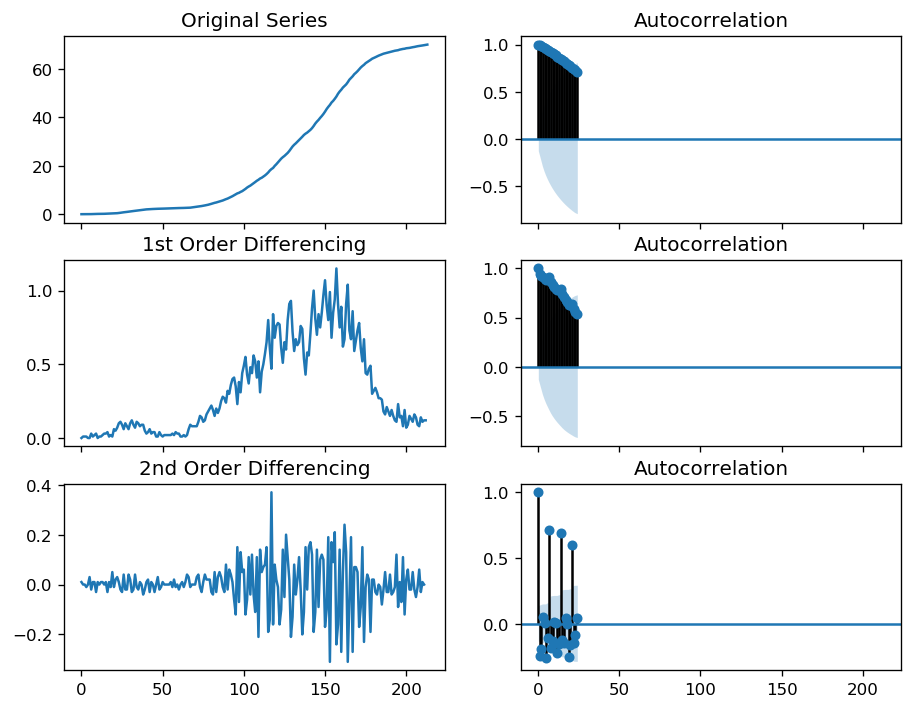

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Orig Seri
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(val); axes[0, 0].set_title('Original Series')
plot_acf(val, ax=axes[0, 1])

# 1st Dif
axes[1, 0].plot(np.diff(val)); axes[1, 0].set_title('1st Order Differencing')
plot_acf(np.diff(val), ax=axes[1, 1])
diffval = np.diff(val)

# 2nd Dif
axes[2, 0].plot(np.diff(diffval)); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(np.diff(diffval), ax=axes[2, 1])
plt.show()

In [7]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
model = pm.auto_arima(val, start_p=1, start_q=1,
test='adf', 
max_p=3, max_q=3, 
m=1, 
d=None, 
seasonal=False, 
start_P=0,
D=0,
trace=True,
error_action='ignore',
suppress_warnings=True,
stepwise=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=-420.152, Time=0.17 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-390.624, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-401.455, Time=0.07 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-414.467, Time=0.15 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-392.616, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=-420.675, Time=0.35 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=-415.095, Time=0.15 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=-418.695, Time=0.56 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=-423.289, Time=0.60 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=-420.804, Time=0.21 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=-421.489, Time=0.79 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=-448.982, Time=0.94 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=-423.364, Time=0.99 sec
 ARIMA(3,2,3)(0,0,0)[0] intercept   : AIC=-462.058, Time=1.06 sec
 ARIMA(3,2,3)(0,0,0)[0]          

Then the best model is:  ARIMA(3,2,3)(0,0,0)

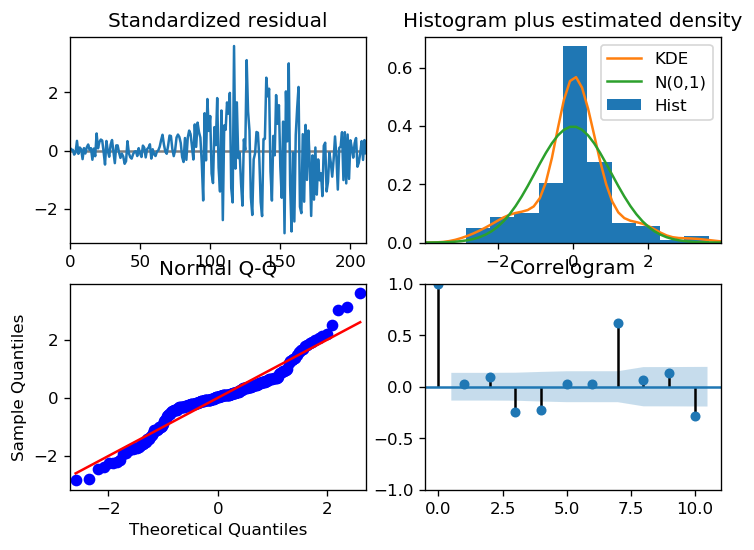

In [8]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

Prediction

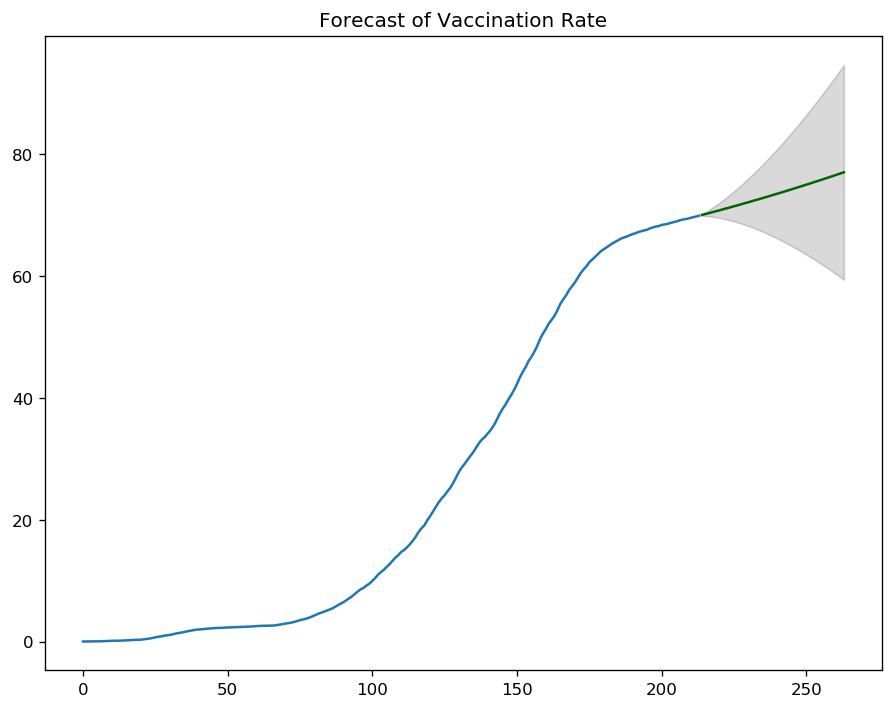

In [9]:

n_periods = 50
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(val), len(val)+n_periods)


fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)


plt.plot(val)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index,
lower_series,
upper_series,
color='k', alpha=.15)
plt.title("Forecast of Vaccination Rate")
plt.show()
